# Compressing CNN models for HLS synthesis

A discription of the original CNN model can be found at https://arxiv.org/abs/1602.04105

A more detailed description of the RML2016.10a dataset can be found at http://pubs.gnuradio.org/index.php/grcon/article/view/11

The RML2016.10a dataset is used for this work (https://www.deepsig.io/datasets)

All models in this work is trained using XSEDE comet cluster: comet.sdsc.xsede.org

Compression code and Conv1D is developed by Duc Hoang (minhduc8199@gmail.com)



In [1]:
# Import all the things we need ---
# by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling1D, ZeroPadding2D, Conv2D, Conv1D
from keras.utils import plot_model
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as cPickle
import random, sys, keras
import tensorflow as tf
import seaborn as sn

from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

#Function for plotting confusion matrix
def plot_confusion_matrix(cm, filename, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):   
    with PdfPages(filename) as pdf:
        # As many times as you like, create a figure fig and save it:
        fig = plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, rotation=45)
        plt.yticks(tick_marks, labels)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        pdf.savefig(fig, dpi = 1000, bbox_inches='tight')

Using TensorFlow backend.


## 1 Full CNN models

#### 1.2.1 Conv2D model

In [2]:
#==================PREPARE DATA=====================

# Prepare the training data
# You will need to seperately download or generate this file
Xd = cPickle.load(open("RML2016.10a_dict.pkl",'rb'), encoding="latin1")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

# Partition the data into training, validation, and test sets while keeping SNR and Mod labels handy for each
np.random.seed(2016)

#Number of samples
n_examples = X.shape[0]
n_train = int(n_examples * 0.6)
n_val = int(n_examples * 0.2)

train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
val_idx = np.random.choice(list(set(range(0,n_examples))-set(train_idx)), size=n_val, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx)-set(val_idx))

X_train = X[train_idx]
X_val = X[val_idx]
X_test =  X[test_idx]

#Add empty dimension at the end for CONV input layer
X_train = X_train.reshape(X_train.shape + (1,))
X_val = X_val.reshape(X_val.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))


def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_val = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), val_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))


#Print out the shapes for different datasets
print ("Total number of samples: ", X.shape[0])
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))

print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))

print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

#Input shape and number of classes
in_shape = list(X_train.shape[1:])
classes = mods
num_classes = len(classes)

print("X_train shape: ", X_train.shape)
print("Number of classes: ", num_classes)

Total number of samples:  220000
number of training examples = 132000
number of validation examples = 44000
number of test examples = 44000
X_train shape: (132000, 2, 128, 1)
Y_train shape: (132000, 11)
X_val shape: (44000, 2, 128, 1)
Y_val shape: (44000, 11)
X_test shape: (44000, 2, 128, 1)
Y_test shape: (44000, 11)
X_train shape:  (132000, 2, 128, 1)
Number of classes:  11


In [3]:
#Load the model
with open('./CNN/model/Conv2D-full.json', 'r') as f:
    model = tf.keras.models.model_from_json(f.read())
    
#Load weights into new model
model.load_weights("./CNN/model/Conv2D-full.h5","r")
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 1, 121, 64)        1088      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 121, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 90, 32)         65568     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 90, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2880)              0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               368768    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [4]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)] 

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
        
    #Plot confusion matrix at snr = 18
    #if snr == 18:
        #plt.figure()
        #plot_confusion_matrix(confnorm, labels=classes, title="Full Conv2D Confusion Matrix (SNR=%d)"%(snr), filename = "Conv2D_full_confmatrix.pdf")
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

Overall Accuracy:  0.08836789900811542
Overall Accuracy:  0.08968609865470852
Overall Accuracy:  0.09143364403018198
Overall Accuracy:  0.09373591707976565
Overall Accuracy:  0.1298342541436464
Overall Accuracy:  0.24645633287608595
Overall Accuracy:  0.37099023709902373
Overall Accuracy:  0.5221719457013575
Overall Accuracy:  0.6231412639405205
Overall Accuracy:  0.7010820559062219
Overall Accuracy:  0.7530751708428246
Overall Accuracy:  0.7611408199643493
Overall Accuracy:  0.7820392890551918
Overall Accuracy:  0.7842605156037992
Overall Accuracy:  0.8002735978112175
Overall Accuracy:  0.7927556166895919
Overall Accuracy:  0.7799909461294704
Overall Accuracy:  0.7842960288808665
Overall Accuracy:  0.7829181494661922
Overall Accuracy:  0.7911832946635731


In [5]:
#Set accuracy to some variable for easy comparison with other models
Conv2D_full_acc = acc

#### 1.2.2 Conv1D model

In [6]:
#==================PREPARE DATA=====================

# Prepare the training data
# You will need to seperately download or generate this file
Xd = cPickle.load(open("RML2016.10a_dict.pkl",'rb'), encoding="latin1")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

# Partition the data into training, validation, and test sets while keeping SNR and Mod labels handy for each
np.random.seed(2016)

#Number of samples
n_examples = X.shape[0]
n_train = int(n_examples * 0.6)
n_val = int(n_examples * 0.2)

train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
val_idx = np.random.choice(list(set(range(0,n_examples))-set(train_idx)), size=n_val, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx)-set(val_idx))

X_train = X[train_idx]
X_val = X[val_idx]
X_test =  X[test_idx]

def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_val = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), val_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

#Flip the last two dimensions
X_train = X_train.reshape((X_train.shape[0],X_train.shape[2],X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0],X_val.shape[2],X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[2],X_test.shape[1]))

#Print out the shapes for different datasets
print ("Total number of samples: ", X.shape[0])
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))

print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))

print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

#Input shape and number of classes
in_shape = list(X_train.shape[1:])
classes = mods
num_classes = len(classes)

print("Number of classes: ", num_classes)

Total number of samples:  220000
number of training examples = 132000
number of validation examples = 44000
number of test examples = 44000
X_train shape: (132000, 128, 2)
Y_train shape: (132000, 11)
X_val shape: (44000, 128, 2)
Y_val shape: (44000, 11)
X_test shape: (44000, 128, 2)
Y_test shape: (44000, 11)
Number of classes:  11


In [7]:
# Load the model
with open('./CNN/model/v3-Conv1D-full.json', 'r') as f:
    model = tf.keras.models.model_from_json(f.read())
#load weights into new model
model.load_weights("./CNN/model/v3-Conv1D-full.h5","r")
model.compile(loss='categorical_crossentropy', optimizer='adam')
#model.summary()

In [8]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)] 

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
        
    #Plot confusion matrix at snr = 18
    #if snr == 18:
        #plt.figure()
        #plot_confusion_matrix(confnorm, labels=classes, title="Full Conv1D Confusion Matrix (SNR=%d)"%(snr), filename = "Conv2D_full_confmatrix.pdf")
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

Overall Accuracy:  0.08881875563570785
Overall Accuracy:  0.08834080717488789
Overall Accuracy:  0.09587217043941411
Overall Accuracy:  0.10049571879224876
Overall Accuracy:  0.14502762430939226
Overall Accuracy:  0.22085048010973937
Overall Accuracy:  0.32821943282194327
Overall Accuracy:  0.49276018099547514
Overall Accuracy:  0.6119888475836431
Overall Accuracy:  0.6943192064923355
Overall Accuracy:  0.7444191343963553
Overall Accuracy:  0.7896613190730838
Overall Accuracy:  0.793732460243218
Overall Accuracy:  0.7978290366350068
Overall Accuracy:  0.8034655722754218
Overall Accuracy:  0.8088033012379643
Overall Accuracy:  0.7858759619737438
Overall Accuracy:  0.7824909747292419
Overall Accuracy:  0.7975978647686833
Overall Accuracy:  0.8032482598607888


In [9]:
#Set accuracy to some variable for easy comparison with other models
Conv1D_full_acc = acc

-------

### 1.2.3 90% pruned model

In [10]:
# Load the model
with open('./CNN/model/Conv1D-0.9.json', 'r') as f:
    model = tf.keras.models.model_from_json(f.read())
#load weights into new model
model.load_weights("./CNN/model/Conv1D-0.9.h5","r")
model.compile(loss='categorical_crossentropy', optimizer='adam')
#model.summary()

In [11]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)] 

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
        
    #Plot confusion matrix at snr = 18
    #if snr == 18:
        #plt.figure()
        #plot_confusion_matrix(confnorm, labels=classes, title="Full Conv1D Confusion Matrix (SNR=%d)"%(snr), filename = "Conv2D_full_confmatrix.pdf")
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

Overall Accuracy:  0.08972046889089269
Overall Accuracy:  0.08654708520179372
Overall Accuracy:  0.09498446515756769
Overall Accuracy:  0.09553853086976115
Overall Accuracy:  0.1289134438305709
Overall Accuracy:  0.21810699588477367
Overall Accuracy:  0.28498372849837283
Overall Accuracy:  0.448868778280543
Overall Accuracy:  0.5738847583643123
Overall Accuracy:  0.6627592425608656
Overall Accuracy:  0.717995444191344
Overall Accuracy:  0.7410873440285205
Overall Accuracy:  0.7712815715622077
Overall Accuracy:  0.7643600180913613
Overall Accuracy:  0.7637938896488828
Overall Accuracy:  0.7771664374140302
Overall Accuracy:  0.7578089633318243
Overall Accuracy:  0.759927797833935
Overall Accuracy:  0.7513345195729537
Overall Accuracy:  0.7781902552204176


In [12]:
#Set accuracy to some variable for easy comparison with other models
Conv1D_90_acc = acc

### 1.2.3 95% pruned model

In [140]:
# Load the model
with open('./CNN/model/Conv1D-0.95v3.json', 'r') as f:
    model = tf.keras.models.model_from_json(f.read())
#load weights into new model
model.load_weights("./CNN/model/Conv1D-0.95v3.h5","r")
model.compile(loss='categorical_crossentropy', optimizer='adam')
#model.summary()

Overall Accuracy:  0.08611361587015329
Overall Accuracy:  0.08654708520179372
Overall Accuracy:  0.08699511762094984
Overall Accuracy:  0.08517350157728706
Overall Accuracy:  0.1072744014732965
Overall Accuracy:  0.15820759030635573
Overall Accuracy:  0.23477452347745234
Overall Accuracy:  0.42036199095022625
Overall Accuracy:  0.5487918215613383
Overall Accuracy:  0.6442741208295762
Overall Accuracy:  0.7120728929384966
Overall Accuracy:  0.7415329768270945
Overall Accuracy:  0.7586529466791394
Overall Accuracy:  0.7607417458163727
Overall Accuracy:  0.7678978568171455
Overall Accuracy:  0.7734983952315452
Overall Accuracy:  0.7419646899049344
Overall Accuracy:  0.7490974729241877
Overall Accuracy:  0.7540035587188612
Overall Accuracy:  0.782830626450116


<Figure size 432x288 with 0 Axes>

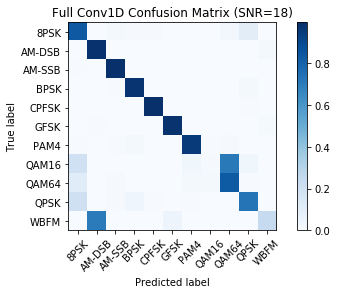

In [141]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)] 

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
        
    #Plot confusion matrix at snr = 18
    if snr == 18:
        plt.figure()
        plot_confusion_matrix(confnorm, labels=classes, title="Full Conv1D Confusion Matrix (SNR=%d)"%(snr), filename = "Conv2D_full_confmatrix.pdf")
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

In [142]:
#Set accuracy to some variable for easy comparison with other models
Conv1D_95_acc = acc

Text(0.5,1,'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

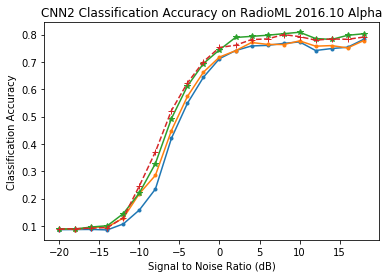

In [143]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: Conv1D_95_acc[x], snrs)), ".-")
plt.plot(snrs, list(map(lambda x: Conv1D_90_acc[x], snrs)), ".-")
plt.plot(snrs, list(map(lambda x: Conv1D_full_acc[x], snrs)), "*-")
plt.plot(snrs, list(map(lambda x: Conv2D_full_acc[x], snrs)), "+--")
plt.xlabel("Signal to Noise Ratio (dB)")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")

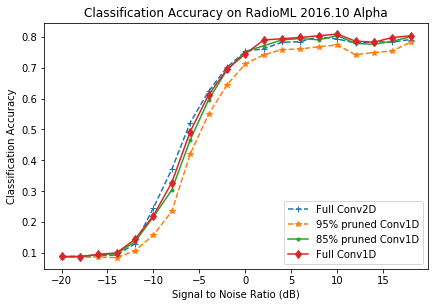

In [266]:
with PdfPages("All_performance.pdf") as pdf:
    # As many times as you like, create a figure fig and save it:
    fig = plt.figure()
    
    # Plot accuracy curve
    plt.plot(snrs, list(map(lambda x: Conv2D_full_acc[x], snrs)),"+--", label = "Full Conv2D")
    plt.plot(snrs, list(map(lambda x: Conv1D_95_acc[x], snrs)), "*--", label = "95% pruned Conv1D")
    plt.plot(snrs, list(map(lambda x: Conv1D_85_acc[x], snrs)), ".-",label = "85% pruned Conv1D")
    plt.plot(snrs, list(map(lambda x: Conv1D_full_acc[x], snrs)), "d-", label = "Full Conv1D")
    
    plt.legend(loc='lower right')
    plt.tight_layout()

    plt.xlabel("Signal to Noise Ratio (dB)", )
    plt.ylabel("Classification Accuracy")
    plt.title("Classification Accuracy on RadioML 2016.10 Alpha")
    pdf.savefig(fig, dpi = 1000, bbox_inches='tight')

----

### 1.2.3 85% pruned model

In [144]:
# Load the model
with open('./CNN/model/Conv1D-0.9.json', 'r') as f:
    model = tf.keras.models.model_from_json(f.read())
#load weights into new model
model.load_weights("./CNN/model/Conv1D-0.85v1.h5","r")
model.compile(loss='categorical_crossentropy', optimizer='adam')
#model.summary()

# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)] 

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
        
    #Plot confusion matrix at snr = 18
    #if snr == 18:
        #plt.figure()
        #plot_confusion_matrix(confnorm, labels=classes, title="Full Conv1D Confusion Matrix (SNR=%d)"%(snr), filename = "Conv2D_full_confmatrix.pdf")
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

Overall Accuracy:  0.08791704238052299
Overall Accuracy:  0.08923766816143498
Overall Accuracy:  0.09409675987572126
Overall Accuracy:  0.09824245155475439
Overall Accuracy:  0.13674033149171272
Overall Accuracy:  0.21719250114311842
Overall Accuracy:  0.30404463040446306
Overall Accuracy:  0.4656108597285068
Overall Accuracy:  0.595724907063197
Overall Accuracy:  0.6920649233543733
Overall Accuracy:  0.7521640091116173
Overall Accuracy:  0.7709447415329769
Overall Accuracy:  0.7899906454630495
Overall Accuracy:  0.7942107643600181
Overall Accuracy:  0.7902416780665754
Overall Accuracy:  0.8037597432370472
Overall Accuracy:  0.7786328655500226
Overall Accuracy:  0.7757220216606499
Overall Accuracy:  0.7855871886120996
Overall Accuracy:  0.8


In [145]:
#Set accuracy to some variable for easy comparison with other models
Conv1D_85_acc = acc

Text(0.5,1,'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

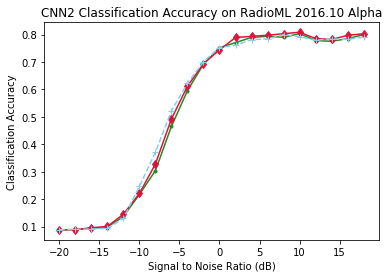

In [146]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: Conv1D_85_acc[x], snrs)), ".-",  c = "forestgreen")
#plt.plot(snrs, list(map(lambda x: Conv1D_90_acc[x], snrs)), ".-")
plt.plot(snrs, list(map(lambda x: Conv1D_full_acc[x], snrs)), "d-", c = "crimson")
plt.plot(snrs, list(map(lambda x: Conv2D_full_acc[x], snrs)), "+--", c = "skyblue")
plt.xlabel("Signal to Noise Ratio (dB)")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")

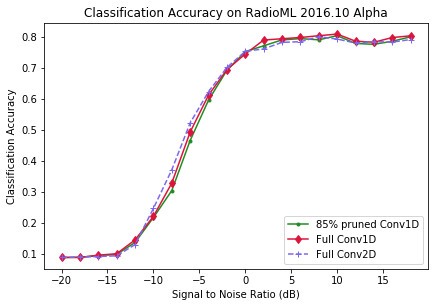

In [147]:
with PdfPages("All_performance.pdf") as pdf:
    # As many times as you like, create a figure fig and save it:
    fig = plt.figure()
    
    # Plot accuracy curve
    plt.plot(snrs, list(map(lambda x: Conv1D_85_acc[x], snrs)), ".-",  c = "forestgreen", label = "85% pruned Conv1D")
    plt.plot(snrs, list(map(lambda x: Conv1D_full_acc[x], snrs)), "d-", c = "crimson", label = "Full Conv1D")
    plt.plot(snrs, list(map(lambda x: Conv2D_full_acc[x], snrs)), "+--", c = "mediumslateblue", label = "Full Conv2D")
    
    plt.legend(loc='lower right')
    plt.tight_layout()

    plt.xlabel("Signal to Noise Ratio (dB)", )
    plt.ylabel("Classification Accuracy")
    plt.title("Classification Accuracy on RadioML 2016.10 Alpha")
    pdf.savefig(fig, dpi = 1000, bbox_inches='tight')

### 1.2.4 Size comparison

In [148]:
import tempfile
import zipfile
import os

keras_file = "./CNN/model/v3-Conv1D-full.h5"

pruned_keras_file_90 = "./CNN/model/Conv1D-0.9v2.h5"

pruned_keras_file_95 = "./CNN/model/Conv1D-0.85v1.h5"

_, zip1 = tempfile.mkstemp('.zip') 
with zipfile.ZipFile(zip1, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(keras_file)
print("Size of the unpruned model before compression: %.2f Mb" % 
      (os.path.getsize(keras_file) / float(2**20)))
print("Size of the unpruned model after compression: %.2f Mb" % 
      (os.path.getsize(zip1) / float(2**20)))

_, zip2 = tempfile.mkstemp('.zip') 
with zipfile.ZipFile(zip2, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(pruned_keras_file_90)
print("Size of the pruned 90 percent model before compression: %.2f Mb" % 
      (os.path.getsize(pruned_keras_file_90) / float(2**20)))
print("Size of the pruned 90 percent model after compression: %.2f Mb" % 
      (os.path.getsize(zip2) / float(2**20)))

_, zip3 = tempfile.mkstemp('.zip') 
with zipfile.ZipFile(zip3, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(pruned_keras_file_95)
print("Size of the pruned 95 percent model before compression: %.2f Mb" % 
      (os.path.getsize(pruned_keras_file_95) / float(2**20)))
print("Size of the pruned 95 percent model after compression: %.2f Mb" % 
      (os.path.getsize(zip3) / float(2**20)))

Size of the unpruned model before compression: 2.45 Mb
Size of the unpruned model after compression: 2.05 Mb
Size of the pruned 90 percent model before compression: 0.83 Mb
Size of the pruned 90 percent model after compression: 0.16 Mb
Size of the pruned 95 percent model before compression: 0.83 Mb
Size of the pruned 95 percent model after compression: 0.20 Mb


## 2. Try some qkeras

In [18]:
from qkeras import *
import copy
from keras.models import load_model

def load_quantized_model(filepath, custom_objects=None):
    if not custom_objects:
        custom_objects = {}

    # let's make a deep copy to make sure our objects are not shared elsewhere
    custom_objects = copy.deepcopy(custom_objects)
    
    custom_objects["QDense"] = QDense
    custom_objects["QConv1D"] = QConv1D
    custom_objects["QConv2D"] = QConv2D
    custom_objects["QDepthwiseConv2D"] = QDepthwiseConv2D
    custom_objects["QAveragePooling2D"] = QAveragePooling2D
    custom_objects["QActivation"] = QActivation
    custom_objects["QBatchNormalization"] = QBatchNormalization
    custom_objects["Clip"] = Clip
    custom_objects["quantized_bits"] = quantized_bits
    custom_objects["bernoulli"] = bernoulli
    custom_objects["stochastic_ternary"] = stochastic_ternary
    custom_objects["ternary"] = ternary
    custom_objects["stochastic_binary"] = stochastic_binary
    custom_objects["binary"] = binary
    custom_objects["quantized_relu"] = quantized_relu
    custom_objects["quantized_ulaw"] = quantized_ulaw
    custom_objects["quantized_tanh"] = quantized_tanh
    custom_objects["quantized_po2"] = quantized_po2
    custom_objects["quantized_relu_po2"] = quantized_relu_po2
    
    model = tf.keras.models.load_model(filepath, custom_objects=custom_objects)
    
    return model

In [2]:
from qkeras.utils import load_qmodel

In [3]:
model = load_qmodel("CNN/model/QConv1D-v1.h5")

Overall Accuracy:  0.09107303877366997
Overall Accuracy:  0.09013452914798206
Overall Accuracy:  0.09720372836218376
Overall Accuracy:  0.11041009463722397
Overall Accuracy:  0.14226519337016574
Overall Accuracy:  0.22359396433470508
Overall Accuracy:  0.30962343096234307
Overall Accuracy:  0.47058823529411764
Overall Accuracy:  0.5896840148698885
Overall Accuracy:  0.6708746618575293
Overall Accuracy:  0.724373576309795
Overall Accuracy:  0.7651515151515151
Overall Accuracy:  0.7829747427502338
Overall Accuracy:  0.7942107643600181
Overall Accuracy:  0.7884176926584587
Overall Accuracy:  0.7872535534158643
Overall Accuracy:  0.7799909461294704
Overall Accuracy:  0.7721119133574007
Overall Accuracy:  0.7709074733096085
Overall Accuracy:  0.7930394431554524


<Figure size 432x288 with 0 Axes>

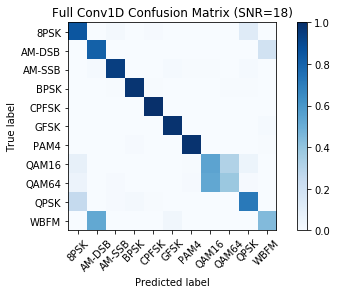

In [6]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)] 

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
        
    #Plot confusion matrix at snr = 18
    if snr == 18:
        plt.figure()
        plot_confusion_matrix(confnorm, labels=classes, title="Full Conv1D Confusion Matrix (SNR=%d)"%(snr), filename = "Conv2D_full_confmatrix.pdf")
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

In [1]:
!ls

CNN                        X_small.npy
CNN_eval_performance.ipynb X_small.txt
README.md                  Y_small.dat
RML2016.10a_dict.pkl       Y_small.npy
Test_quantization.ipynb    Y_small.txt
X_small.dat


In [28]:
model.save_weights("cac.h5")

In [29]:
import tempfile
import zipfile
import os

quantized_keras_file = "cac.h5"

_, zip3 = tempfile.mkstemp('.zip')
with zipfile.ZipFile(zip3, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(quantized_keras_file)
print("Size of the pruned 95 percent model before compression: %.2f Mb" % 
      (os.path.getsize(quantized_keras_file) / float(2**20)))
print("Size of the pruned 95 percent model after compression: %.2f Mb" % 
      (os.path.getsize(zip3) / float(2**20)))

os.remove("cac.5")

Size of the pruned 95 percent model before compression: 0.84 Mb
Size of the pruned 95 percent model after compression: 0.75 Mb


-------

# Quantized CNN model

## 1. Weight quantization

In [177]:
from hls4ml.model.profiling import numerical
from hls4ml.converters import keras_to_hls
import matplotlib.pyplot as plt
import yaml
import hls4ml

In [178]:
from tensorflow import keras

In [179]:
# Load the model
with open('./CNN/model/Conv1D-0.9.json', 'r') as f:
    model = tf.keras.models.model_from_json(f.read())
#load weights into new model
model.load_weights("./CNN/model/Conv1D-0.85v1.h5","r")
model.compile(loss='categorical_crossentropy', optimizer='adam')
#model.summary()

In [154]:
#model.save("Conv1d-85.h5")

In [263]:
model = keras.models.load_model("Conv1d-85.h5", compile=False, custom_objects={"GlorotUniform": tf.keras.initializers.glorot_uniform})
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [267]:
# serialize model to JSON
model_json = model.to_json()
with open("Conv1.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("Conv1.h5")

In [252]:
with open("keras-config-2.yml", 'r') as ymlfile:
    config = yaml.load(ymlfile)

/Users/duc_hoang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [253]:
hls_model = keras_to_hls(config)

Interpreting Sequential
Input shape: [128, 2]
Topology:
Layer name: conv1, layer type: Conv1D, current shape: [None, 126, 128]
Layer name: conv2, layer type: Conv1D, current shape: [None, 124, 128]
Layer name: max_pooling1d, layer type: MaxPooling1D, current shape: [None, 62, 128]
Layer name: conv3, layer type: Conv1D, current shape: [None, 60, 64]
Layer name: conv4, layer type: Conv1D, current shape: [None, 58, 64]
Layer name: conv5, layer type: Conv1D, current shape: [None, 56, 32]
Layer name: conv6, layer type: Conv1D, current shape: [None, 54, 32]
Layer name: max_pooling1d_1, layer type: MaxPooling1D, current shape: [None, 27, 32]
Layer name: dense1, layer type: Dense, current shape: [None, 128]
Layer name: dense2, layer type: Dense, current shape: [None, 11]
Layer name: activation, layer type: Activation, current shape: [None, 11]
Creating HLS model


Profiling weights
Profiling activations
   conv1
   conv2
   max_pooling1d
   conv3
   conv4
   dropout
   conv5
   conv6
   dropout_1
   max_pooling1d_1
   flatten
   dense1
   dense2
   activation


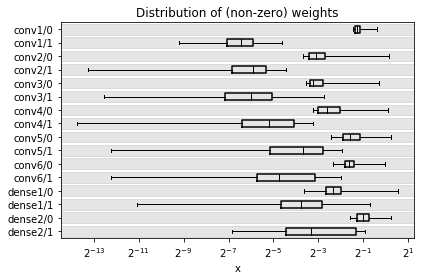

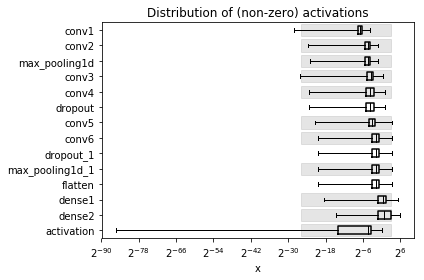

In [254]:
ap, wp = numerical(keras_model = model, hlsmodel=hls_model, X=X_sim)
plt.show()

In [262]:
wp.savefig("weights.pdf")

-----

## Compare AUC

In [13]:
from hls4ml.model.profiling import numerical
from hls4ml.converters import keras_to_hls
import matplotlib.pyplot as plt
import yaml
import hls4ml

------

In [2]:
# Load full the model
with open('./CNN/model/v3-Conv1D-full.json', 'r') as f:
    full_model = tf.keras.models.model_from_json(f.read())
#load weights into new model
full_model.load_weights("./CNN/model/v3-Conv1D-full.h5","r")
full_model.compile(loss='categorical_crossentropy', optimizer='adam')

# Load the pruned model
with open('./CNN/model/Conv1D-0.9.json', 'r') as f:
    pruned_model = tf.keras.models.model_from_json(f.read())
#load weights into new model
pruned_model.load_weights("./CNN/model/Conv1D-0.85v1.h5","r")
pruned_model.compile(loss='categorical_crossentropy', optimizer='adam')

#Create the quantized model
with open("conv-model/config-conv.yml", 'r') as ymlfile:
    config = yaml.load(ymlfile)

#Create hls model using conversion tool
from hls4ml.converters import keras_to_hls
hls_model = keras_to_hls(config)

hls_model.compile()

In [173]:
#Make predictions
Y_pred_full = full_model.predict(X_test)
Y_pred_pruned = pruned_model.predict(X_test)
Y_pred_quant = hls_model.predict(X_test)

In [200]:
n_classes = truth_df.shape[1]

# Compute ROC curve and ROC area for each class
fpr_full = dict()
tpr_full = dict()
roc_auc_full = dict()

fpr_pruned = dict()
tpr_pruned = dict()
roc_auc_pruned = dict()

fpr_quant = dict()
tpr_quant = dict()
roc_quant = dict()

sum_pruned_ratio = 0
sum_quant_ratio = 0

for i in range(n_classes):
    
    #AUC from the full model
    fpr_full[i], tpr_full[i], _ = roc_curve(Y_test[:, i], Y_pred_full[:, i])
    roc_auc_full[i] = auc(fpr_full[i], tpr_full[i])
    print('Output {}: Keras auc = {:.1f}'.format(classes[i], roc_auc_full[i] * 100))
    
    #AUC of pruned model
    fpr_pruned[i], tpr_pruned[i], _ = roc_curve(Y_test[:, i], Y_pred_pruned[:, i])
    roc_auc_pruned[i] = auc(fpr_pruned[i], tpr_pruned[i])
    print('Output {}: Pruned Keras auc = {:.1f}'.format(classes[i], roc_auc_pruned[i] * 100))
    print('Output {}: Ratio Pruned/Full = {:.2f}'. format(classes[i], roc_auc_pruned[i]/roc_auc_full[i])) #Calculate the ratio
    sum_pruned_ratio += roc_auc_pruned[i]/roc_auc_full[i]
    
    #AUC of quantized model
    fpr_quant[i], tpr_quant[i], _ = roc_curve(Y_test[:, i], Y_pred_quant[:, i])
    roc_auc_quant[i] = auc(fpr_quant[i], tpr_quant[i])
    print('Output {}: Keras auc = {:.1f}'.format(classes[i], roc_auc_quant[i] * 100))
    print('Output {}: Ratio Quantized/Full = {:.2f}'. format(classes[i], roc_auc_quant[i]/roc_auc_full[i])) #Calculate the rat
    sum_quant_ratio += roc_auc_quant[i]/roc_auc_full[i]

print("Average ratio pruned/full: {:.2f}".format(sum_pruned_ratio/n_classes))
print("Average ratio quant/full: {:.2f}".format(sum_quant_ratio/n_classes))

Output 8PSK: Keras auc = 87.6
Output 8PSK: Pruned Keras auc = 87.2
Output 8PSK: Ratio Pruned/Full = 1.00
Output AM-DSB: Keras auc = 92.8
Output AM-DSB: Pruned Keras auc = 92.3
Output AM-DSB: Ratio Pruned/Full = 0.99
Output AM-SSB: Keras auc = 87.9
Output AM-SSB: Pruned Keras auc = 87.6
Output AM-SSB: Ratio Pruned/Full = 1.00
Output BPSK: Keras auc = 91.9
Output BPSK: Pruned Keras auc = 91.8
Output BPSK: Ratio Pruned/Full = 1.00
Output CPFSK: Keras auc = 92.2
Output CPFSK: Pruned Keras auc = 92.1
Output CPFSK: Ratio Pruned/Full = 1.00
Output GFSK: Keras auc = 93.5
Output GFSK: Pruned Keras auc = 93.5
Output GFSK: Ratio Pruned/Full = 1.00
Output PAM4: Keras auc = 93.5
Output PAM4: Pruned Keras auc = 92.9
Output PAM4: Ratio Pruned/Full = 0.99
Output QAM16: Keras auc = 87.7
Output QAM16: Pruned Keras auc = 87.1
Output QAM16: Ratio Pruned/Full = 0.99
Output QAM64: Keras auc = 91.6
Output QAM64: Pruned Keras auc = 91.0
Output QAM64: Ratio Pruned/Full = 0.99
Output QPSK: Keras auc = 87.1
Outp